# 0. Imports

### Standard imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Project imports

In [2]:
from src.libs.preprocessing import DataLoader

# 1. Load and read the data

## 1.a Loading

In [3]:
# data path
path_train_x = "data/input/denoising/train"
path_train_y = "data/input/voice_origin/train"

In [4]:
data_loader = DataLoader(path_x=path_train_x, path_y=path_train_y)

Import summary:
- Data imported successfully!
- Number of noised samples: 2118
- Number of original samples: 2118
- Signal shapes in noised samples: [80000]
- Signal shapes in original samples: [80000]
- Correspondance between both data sets: True.


## 1.b Playing some sounds

In [5]:
# chose at random an extract to read
sequence = np.random.choice(list(data_loader.data_x.keys()))

In [6]:
# listen to the extract without noise
data_loader.play_wav(sequence, noised=False)

Sampling frequency: 8000 Hz
Dimension: (80000,)


In [7]:
data_loader.play_wav(sequence, noised=True)

Sampling frequency: 8000 Hz
Dimension: (80000,)


## 1.c Displaying the time serie

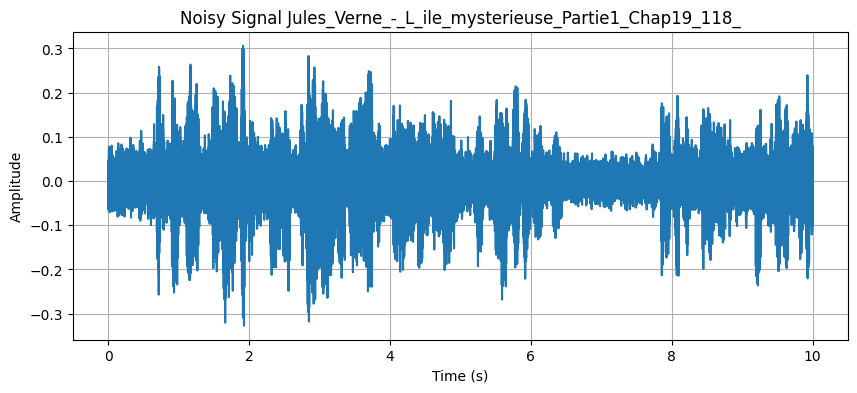

In [8]:
data_loader.display_signal(sequence, noised=True)